In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sn
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [82]:
def gen_ar_data(order: int, n_points: int, coeff=None, initial=None):
    """ 
    Args:
        order - order of the AR model
        n_points - number of points to generate for this model
        coeff - coefficient that will be used in the model,
                [a0, a1, a2] -> xn = a0 + a1*x1 + a2*x0 + noise()
        initial - insitial values for the model,
                [x0, x1, x2, ...]
    """
    # Check if arguments are matching the requirements
    assert len(coeff) == (order + 1)
    assert len(initial) == order
    print(f"Coefficient used: {coeff}")
    # Generate noise for every point
    points = np.random.random(order + n_points)
    # We already have the first points
    points[:order] = initial
    # This will be used to calculate multiplications
    mult = coeff[1:][::-1]
    # This will be simply added to every value
    add = coeff[0]

    for i in range(order, order + n_points):
        # To the noise add the a0 and the sum of multiplication bewteen a and last points from points
        points[i] += add + np.matmul(mult, points[i-order:i])
        
    return pd.Series(points)
       

Coefficient used: [0.46294106 0.43312218]
AR::Lag: 1
AR::coeffs: const      0.380783
L1.Data    0.751256
dtype: float64


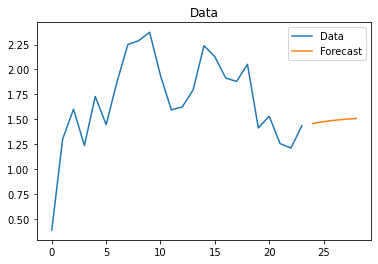

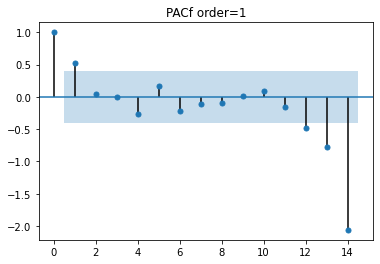

Coefficient used: [0.5627972  0.41908353 0.40287607]
AR::Lag: 2
AR::coeffs: const      0.092667
L1.Data    0.966516
L2.Data    0.004365
dtype: float64


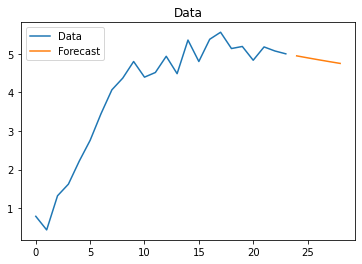

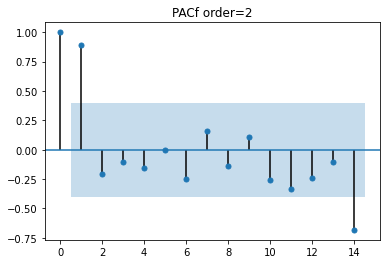

Coefficient used: [0.09978762 0.14504704 0.13351728 0.93697229]
AR::Lag: 3
AR::coeffs: const      0.571883
L1.Data         NaN
L2.Data         NaN
L3.Data    0.831919
dtype: float64


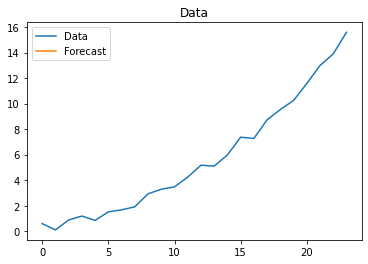

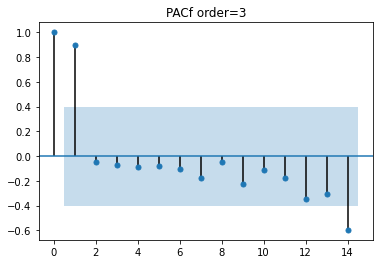

Coefficient used: [0.91693246 0.88348531 0.94519965 0.98579699 0.80276329]
AR::Lag: 4
AR::coeffs: const      1.323477
L1.Data         NaN
L2.Data         NaN
L3.Data         NaN
L4.Data    0.836209
dtype: float64


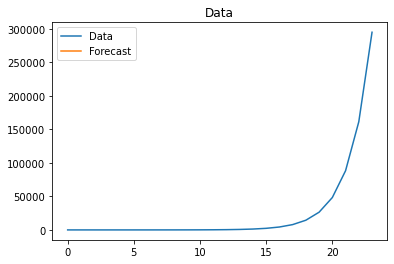

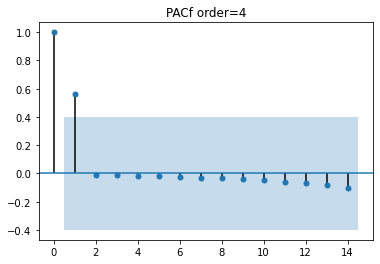

Coefficient used: [0.95659721 0.79872544 0.22664109 0.826204   0.85819529 0.32424236]
AR::Lag: 5
AR::coeffs: const      1.457143
L1.Data         NaN
L2.Data         NaN
L3.Data         NaN
L4.Data         NaN
L5.Data    0.613135
dtype: float64


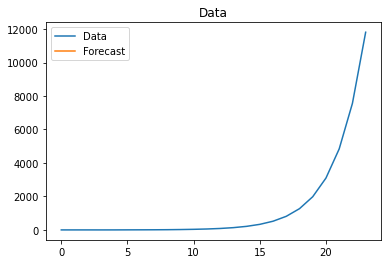

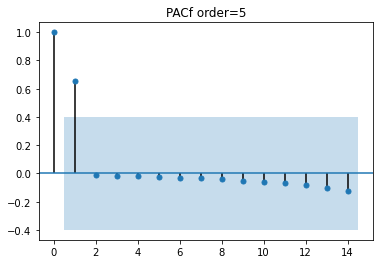

In [85]:
for i in range(1,6):
    #generate the data
    data = gen_ar_data(
        order=i,
        n_points=24-i,
        coeff=np.random.random(size=i+1),
        initial=np.random.random(size=i)
    ).rename("Data")
    # try to fit the model
    model = AR(data.dropna())
    AR1fit = model.fit(maxlag=i,method='mle', missign='drop')
    print(f"AR::Lag: {AR1fit.k_ar}")
    print(f"AR::coeffs: {AR1fit.params}")
    
    fcast = AR1fit.predict(start=len(data), end=len(data)+4, dynamic=False).rename("Forecast")
    
    #plot data
    data.plot(title="Data", legend=True)
    fcast.plot(legend=True)
    
    plot_pacf(data, title=f"PACf order={i}");
    plt.show();
    
    

I'm not sure if there is an issue with the method itself or this is because of the initial values for the model but AR() don't want to work in every scenario. Below I tried very naive approach for creating the data but still the same issue with AR() method.

In [127]:
a0, a1, a2 = 1, 0.5, 0.1
f = lambda x0, x1: a0 + a1 * x1 + a2*x0 + np.random.random()
x0, x1 = [0, 1]
points = [x0, x1]
for i in range(10):
    points.append(f(*points[-2:]))
points = pd.Series(points)

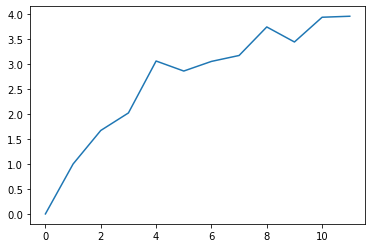

In [128]:
points.plot()

Coefficient used: [1, 0.5, 0.1]


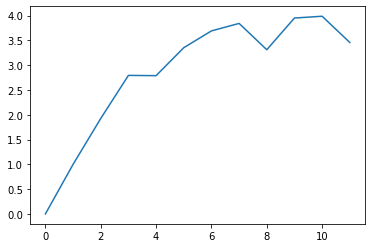

In [129]:
data2 = gen_ar_data(order=2, n_points=10, coeff=[a0, a1, a2], initial=[x0, x1])
data2.plot()

In [130]:
model = AR(points)
ARfit = model.fit(maxlag=2, method='mle')
print(f"Lag: {ARfit.k_ar}")
print(f"coeffs: \n{ARfit.params}")

model2 = AR(data2)
ARfit2 = model2.fit(maxlag=2, method='mle')
print(f"Lag: {ARfit2.k_ar}")
print(f"coeffs: \n{ARfit2.params}")

Lag: 2
coeffs: 
const    0.142086
L1.y     1.241680
L2.y    -0.309283
dtype: float64
Lag: 2
coeffs: 
const    0.233467
L1.y     1.427335
L2.y    -0.540509
dtype: float64


This time it worked

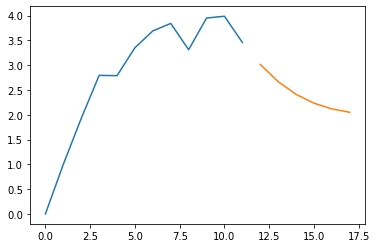

In [131]:
start=len(data2)
end=len(data2) + 5
predictions = pd.Series(ARfit2.predict(start=start, end=end, dynamic=False))
data2.plot()
predictions.plot()

Coefficient used: [0, 0.8, 0.3, 0.1]


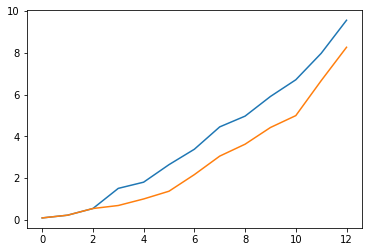

In [134]:
a0, a1, a2, a3 = 0, 0.8, 0.3, 0.1
f = lambda x0, x1, x2: a0 + a1 * x2 + a2*x1 + a3*x0 + np.random.random()
x0, x1, x2 = [0.1, 0.23, 0.55]
points = [x0, x1, x2]
for i in range(10):
    points.append(f(*points[-3:]))
points = pd.Series(points)
points.plot()
data2 = gen_ar_data(order=3, n_points=10, coeff=[a0, a1, a2, a3], initial=[x0, x1, x2])
data2.plot()

In [135]:
model = AR(data2)
ARfit = model.fit(maxlag=3, method='mle')
print(f"Lag: {ARfit.k_ar}")
print(f"coeffs: \n{ARfit.params}")

Lag: 3
coeffs: 
const    0.285086
L1.y          NaN
L2.y          NaN
L3.y     0.264790
dtype: float64


Here again it's not working.